In [1]:
## Importar librerias
from linares_plot import *
import statsmodels.api as sm
from scipy import stats
import statsmodels.formula.api as smf
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM
import itertools
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels
import scikit_posthocs as sp
from statsmodels.stats.proportion import proportions_ztest


%load_ext autoreload
%autoreload

In [2]:
c_togh = 'powderblue'

In [3]:
df_ = pd.read_excel('df_proces.xlsx')

df = df_.loc[(df_['juego']==1) | (df_['juego']==2)  | (df_['juego']==22)   | (df_['juego']==23)   | 
             (df_['juego']==3) | (df_['juego']==4)   | (df_['juego']==5)  | (df_['juego']==6)   | 
             (df_['juego']==7)   | (df_['juego']==8) ] ## remove 0 and 9
df = df.reset_index();

df_o = df_.loc[(df_['juego']==1) | (df_['juego']==2)  | 
             (df_['juego']==3) | (df_['juego']==4)   | (df_['juego']==5)  | (df_['juego']==6)   | 
             (df_['juego']==7)   | (df_['juego']==8) ] ## remove 0 and 9

df_o = df_o.reset_index()

In [4]:
#df_subset =df_[['recuerdo', 'tiempo', 'juego', 'subj', 'session_o']]
#df_subset.to_csv('r_analysis.csv') ### correr analisis en R (mixed model con pvalues)

### memory decay with time

In [5]:
total_juegos_rec={}

for sub in df_o.subj.unique():
    for ti in df_o.tiempo.unique():
        keyl= str(sub) + '_' + str(ti)
        tot = df_o.loc[(df_o['tiempo']==ti) & (df_o['subj']==sub), 'recuerdo' ].sum()
        total_juegos_rec[keyl]=tot

###

number_t=[]

for i in range(len(df_o)):
    sub = df_o.iloc[i].subj
    ti =df_o.iloc[i].tiempo
    keyl=str(sub) + '_' + str(ti)
    number_t.append(total_juegos_rec[keyl])


In [6]:
df_o['total_rec']=number_t

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecatio

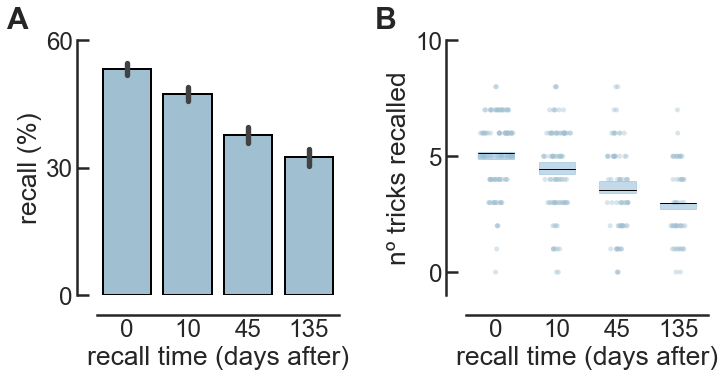

In [7]:
f = plt.figure(figsize=(10,5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

plt.subplot(121)
juegos = df_.juego.unique()
#fig.suptitle('memoria con tiempo', fontsize=23)
g =sns.barplot(x="tiempo", y="recuerdo",data=df, estimator=np.mean, 
             order=[1,2,3,4], ci=69,  color='#98c1d9',  edgecolor='black', ecolor='k')
plt.xlabel('')
plt.ylabel('recall (%)')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.tick_params(direction='in') #direction
plt.ylim(0,0.6);
plt.yticks([0, 0.3, 0.6], ['0', '30', '60'])
plt.xticks([0,1,2,3], ['0', '10', '45', '135'], fontsize=14, rotation=90)
plt.xlabel('recall time (days after)')
#plt.title('memory decay')
plt.tick_params(axis='x', length=0)
adjust_spines(plt.gca(), ['left', 'bottom'])


###

plt.subplot(122)
linares_plot(x="tiempo", y="total_rec", df=df_o, order=[1,2,3,4], palette=['#98c1d9'],
             by_subj=True, subj_col='subj', reps=10, CI=0.68, point_size=5, fill_box=True,
            alpha_box=0.6)
#plt.title('')
plt.ylabel('nº tricks recalled')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.tick_params(direction='in') #direction
plt.ylim(-1,10);
plt.yticks([0,5,10])
plt.xticks([0,1,2,3], ['0', '10', '45', '135'])#, rotation=90)
plt.xlabel('recall time (days after)')
#plt.title('memory decay')
plt.tick_params(axis='x', length=0)


##
plt.tight_layout(w_pad=4)

f.text(0.0, 1.0, "A", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30);
f.text(0.51, 1.0, "B", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30);


               
    

In [8]:
### mixed linear model con total rec
r = smf.mixedlm(formula='total_rec~tiempo', data=df_o, groups=df_o['subj']).fit()
print(r.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: total_rec 
No. Observations: 2680    Method:             REML      
No. Groups:       117     Scale:              0.8126    
Min. group size:  8       Likelihood:         -3767.7946
Max. group size:  32      Converged:          Yes       
Mean group size:  22.9                                  
--------------------------------------------------------
             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     5.939    0.147  40.438 0.000  5.651  6.227
tiempo       -0.797    0.018 -44.812 0.000 -0.832 -0.762
Group Var     2.336    0.355                            



In [9]:
### Dunn tets multiple comparison (recuerdo)
print('Multiple comparison Dunn test')
print( '==============================')
pc = sp.posthoc_dunn(df, val_col='recuerdo', group_col='tiempo')
sign_pc = pc<0.05
print( '1-2    ' + str(round(pc.iloc[0,1],4)) + '   ' +  str(sign_pc.iloc[0,1]) )
print( '1-3    ' + str(round(pc.iloc[0,2],4)) + '   ' +  str(sign_pc.iloc[0,2]) )
print( '2-3    ' + str(round(pc.iloc[1,2],4)) + '   ' +  str(sign_pc.iloc[1,2]) )
print( '1-4    ' + str(round(pc.iloc[0,3],4)) + '   ' +  str(sign_pc.iloc[0,3]) )
print( '2-4    ' + str(round(pc.iloc[1,3],4)) + '   ' +  str(sign_pc.iloc[1,3]) )
print( '3-4    ' + str(round(pc.iloc[2,3],4)) + '   ' +  str(sign_pc.iloc[2,3]) )

Multiple comparison Dunn test
1-2    0.0069   True
1-3    0.0   True
2-3    0.0001   True
1-4    0.0   True
2-4    0.0   True
3-4    0.0639   False


In [10]:
### All tricks different from 0 at time 4
for J in range(1,9):
    number_detections_r = sum(df.loc[(df['tiempo']==4) & (df['juego']==J), 'recuerdo'])
    number_obs_r = len(df.loc[(df['tiempo']==4) & (df['juego']==J), 'recuerdo'])

    number_detections_n = 0
    number_obs_n = len(df.loc[(df['tiempo']==4) & (df['juego']==J), 'recuerdo'])

    count = np.array([number_detections_r, number_detections_n]);
    nobs = np.array([number_obs_r, number_obs_n]);
    stat, pval = proportions_ztest(count, nobs);
    print(J, '', '',  round(stat,2) , '', '', round(pval, 4))

1   3.14   0.0017
2   2.29   0.022
3   4.34   0.0
4   3.5   0.0005
5   8.02   0.0
6   5.57   0.0
7   5.57   0.0
8   6.32   0.0


### all data (Supl. 1)

In [11]:
s1t1='#03045e'
s1t2='#0077b6'
s1t3='#00b4d8'
s1t4='#caf0f8'


s2t1='#a31621'
s2t2='#b23a48'
s2t3='#fcb9b2'
s2t4='#fed0bb'


s3t1='#114b5f'
s3t2='#1a936f'
s3t3='#88d498'
s3t4='#c6dabf'

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


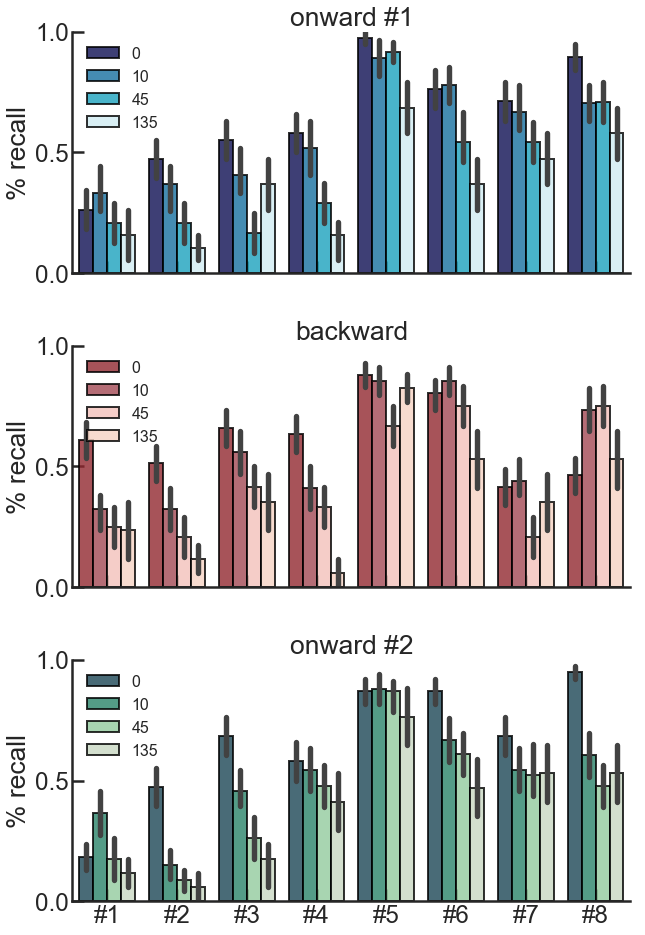

In [12]:
f = plt.figure(figsize=(10,16))
ax1 = f.add_subplot(311)
ax2 = f.add_subplot(312)
ax3 = f.add_subplot(313)
axs=[ax1, ax2, ax3]

dfs1=df.loc[df['session']==1]
dfs2=df.loc[df['session']==2]
dfs3=df.loc[df['session']==3]

dfs_all=[dfs1,dfs2,dfs3]
pales_=[[s1t1, s1t2, s1t3, s1t4],[s2t1, s2t2, s2t3, s2t4],[s3t1, s3t2, s3t3, s3t4]]
titles_=['onward #1', 'backward', 'onward #2']


for idx_sess, sess_ in enumerate([1,2,3]):
    axn=axs[idx_sess]
    pal_sess=pales_[idx_sess]
    dfss=dfs_all[idx_sess]
    title_s=titles_[idx_sess]
    g=sns.barplot(x="juego", y="recuerdo", hue='tiempo', hue_order=[1,2,3,4],
                data=dfss, estimator=np.mean, ax=axn,
                 order=[1,2,3,4,5,6,7,8], ci=68, palette=pal_sess, 
                  edgecolor='black', ecolor='k', alpha=0.8)
    axn.set_xlabel('')
    axn.set_ylabel('% recall')
    axn.spines['right'].set_visible(False)
    axn.spines['top'].set_visible(False)
    axn.tick_params(direction='in') #direction
    axn.set_ylim(0,1)
    axn.set_yticks([0, 0.5, 1.])
    #axn.set_yticklabels(['0', '50', '100'])
    axn.tick_params(direction='in') #direction
    axn.set_title(title_s)
    # adjust_spines(plt.gca(), ['left', 'bottom'])
    # l = plt.legend(loc=1, frameon=False, prop={'size': 20} )
    if sess_==3: 
        #axn.set_xticks(range(8))
        axn.set_xticklabels(['#1', '#2', '#3', '#4', '#5', '#6', '#7', '#8'])
    else:
        #axn.set_xticks(range(8))
        axn.set_xticklabels(['', '', '', '', '', '', '', ''])
    
    
    #axn.legend(loc='best', frameon=False, prop={'size': 20})#, labels=['justo depsués', 'dos semanas', 'mes y medio'])
    h, l = axn.get_legend_handles_labels()
    labels=['0', '10', '45', '135']
    axn.legend(h, labels, title="", frameon=False, prop={'size': 16})
    
    #plt.legend(title='Smoker', loc='upper left', labels=['Hell Yeh', 'Nah Bruh'])
  
    #if sess_==3:
    #    axn.set_xticklabels(['montones', 'frotar', 'monedón', 'operario', 'matrix', 'invisible', 'esencias',
    #                   'deletreos', 'granda', 'instrucciones'], rotation=45)
    #else:
    #    axn.set_xticklabels([])
        
        

plt.subplots_adjust(wspace=0.3, hspace=0.3)  

### group comparion (supl. 2)

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


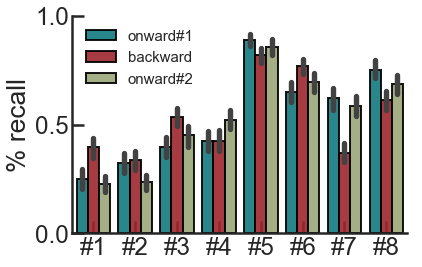

In [13]:
sns.barplot(x="juego", y="recuerdo", hue='session', hue_order=[1,2,3],
            data=df, estimator=np.mean, 
             order=[1,2,3,4,5,6,7,8], ci=68, palette=['#00898f', '#b0111b', '#9dad71'], 
              edgecolor='black', ecolor='k', alpha=0.9)

plt.gca().set_xlabel('')
plt.gca().set_ylabel('% recall')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().tick_params(direction='in') #direction
plt.gca().set_ylim(0,1)
plt.gca().set_yticks([0, 0.5, 1.])
plt.gca().tick_params(direction='in') #direction
plt.gca().set_xticklabels(['#1', '#2', '#3', '#4', '#5', '#6', '#7', '#8'])

h, l = plt.gca().get_legend_handles_labels()
labels=['onward#1', 'backward', 'onward#2']
plt.gca().legend(h, labels, title="", frameon=False, prop={'size': 15});

In [14]:
####### Multiple comparisons of effects collapsing by time
for effect in [1,2,3,4,5,6,7,8]:
    print( '                                 ' + str(effect) )
    print( '==============================================================================')
    print('Multiple comparison Dunn test')
    print( '==============================')
    pc = sp.posthoc_dunn(df_.loc[df_['juego']==effect], val_col='recuerdo', group_col='session')
    sign_pc = pc<0.05
    print( '1-2    ' + str(round(pc.iloc[0,1],3)) + '   ' +  str(sign_pc.iloc[0,1]) )
    print( '1-3    ' + str(round(pc.iloc[0,2],3)) + '   ' +  str(sign_pc.iloc[0,2]) )
    print( '2-3    ' + str(round(pc.iloc[1,2],3)) + '   ' +  str(sign_pc.iloc[1,2]) )

                                 1
Multiple comparison Dunn test
1-2    0.016   True
1-3    0.687   False
2-3    0.005   True
                                 2
Multiple comparison Dunn test
1-2    0.843   False
1-3    0.147   False
2-3    0.094   False
                                 3
Multiple comparison Dunn test
1-2    0.041   True
1-3    0.438   False
2-3    0.205   False
                                 4
Multiple comparison Dunn test
1-2    0.958   False
1-3    0.152   False
2-3    0.131   False
                                 5
Multiple comparison Dunn test
1-2    0.14   False
1-3    0.49   False
2-3    0.432   False
                                 6
Multiple comparison Dunn test
1-2    0.051   False
1-3    0.461   False
2-3    0.225   False
                                 7
Multiple comparison Dunn test
1-2    0.0   True
1-3    0.607   False
2-3    0.001   True
                                 8
Multiple comparison Dunn test
1-2    0.027   True
1-3    0.301   False
2-3    

## collapsing onward#1 and onward#2 (supl. 3)

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


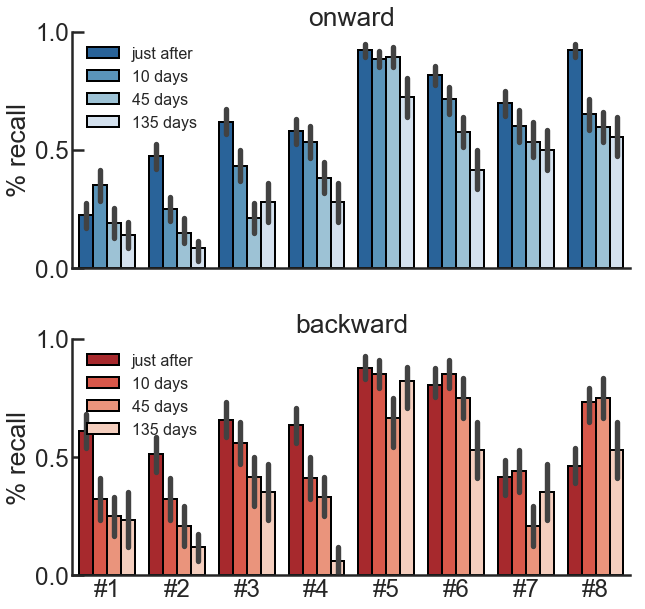

In [15]:
f = plt.figure(figsize=(10,10))
ax1 = f.add_subplot(211)
ax2 = f.add_subplot(212)

axs=[ax1, ax2]

df_['session_o']=df_['session'].replace([1,2,3], ['normal', 'revés', 'normal'])

dfs1=df_.loc[df_['session_o']=='normal']
dfs2=df_.loc[df_['session_o']=='revés']


dfs_all=[dfs1,dfs2]
pales_=['Blues_r','Reds_r']
titles_=['onward', 'backward']


for idx_sess, sess_ in enumerate([1,2]):
    axn=axs[idx_sess]
    pal_sess=pales_[idx_sess]
    dfss=dfs_all[idx_sess]
    title_s=titles_[idx_sess]
    g=sns.barplot(x="juego", y="recuerdo", hue='tiempo', hue_order=[1,2,3,4],
                data=dfss, estimator=np.mean, ax=axn,
                 order=[1,2,3,4,5,6,7,8], ci=68, palette=pal_sess, edgecolor='black', ecolor='k')
    axn.set_xlabel('')
    axn.set_ylabel('% recall')
    axn.spines['right'].set_visible(False)
    axn.spines['top'].set_visible(False)
    axn.tick_params(direction='in') #direction
    #axn.set_ylim(0,1.2)
    axn.set_yticks([0, 0.5, 1.])
    #axn.set_yticklabels(['0', '50', '100'])
    axn.tick_params(direction='in') #direction
    axn.set_title(title_s)
    # adjust_spines(plt.gca(), ['left', 'bottom'])
    # l = plt.legend(loc=1, frameon=False, prop={'size': 20} )
    if sess_==2: 
        #axn.set_xticks(range(8))
        axn.set_xticklabels(['#1', '#2', '#3', '#4', '#5', '#6', '#7', '#8'])
    else:
        #axn.set_xticks(range(8))
        axn.set_xticklabels(['', '', '', '', '', '', '', ''])
        #axn.set_xticklabels(nombre_juegos_ext, rotation=90, fontsize=16)
    
    
    #axn.legend(loc='best', frameon=False, prop={'size': 20})#, labels=['justo depsués', 'dos semanas', 'mes y medio'])
    h, l = axn.get_legend_handles_labels()
    labels=['just after', '10 days', '45 days', '135 days']
    axn.legend(h, labels, title="", frameon=False, prop={'size': 16})
    
    #plt.legend(title='Smoker', loc='upper left', labels=['Hell Yeh', 'Nah Bruh'])
  
    #if sess_==3:
    #    axn.set_xticklabels(['montones', 'frotar', 'monedón', 'operario', 'matrix', 'invisible', 'esencias',
    #                   'deletreos', 'granda', 'instrucciones'], rotation=45)
    #else:
    #    axn.set_xticklabels([])
        
        

plt.subplots_adjust(wspace=0.3, hspace=0.3)  

In [16]:
### Diference between onward-backward in time 0: just 1, 8 and 7
for idx_j, juego in enumerate(range(1,9)): #[1,8]
    #
    for idx_t, time in enumerate([1]):
        #statistical annotation
        number_detections_r = sum(df_.loc[(df_['tiempo']==time) & (df_['juego']==juego) & (df_['session_o']=='revés'), 'recuerdo'])
        number_obs_r = len(df_.loc[(df_['tiempo']==time) & (df_['juego']==juego) & (df_['session_o']=='revés'), 'recuerdo'])
        number_detections_n = sum(df_.loc[(df_['tiempo']==time) & (df_['juego']==juego) & (df_['session_o']=='normal'), 'recuerdo'])
        number_obs_n = len(df_.loc[(df_['tiempo']==time) & (df_['juego']==juego) & (df_['session_o']=='normal'), 'recuerdo'])

        count = np.array([number_detections_r, number_detections_n]);
        nobs = np.array([number_obs_r, number_obs_n]);
        stat, pval = proportions_ztest(count, nobs);
        #print(number_obs_n)
        #print(number_obs_r)
        print(str(juego) + '_' + str(time) + ' ' + '' +str( round(stat,2)) + ' ' + ' ' + str( round(pval, 4)) )

1_1 4.15  0.0
2_1 0.4  0.6909
3_1 0.43  0.6676
4_1 0.58  0.5612
5_1 -0.76  0.447
6_1 -0.14  0.8854
7_1 -2.98  0.0029
8_1 -5.54  0.0


In [17]:
### Extinguished at t=4 for trick and session
## 1 y 8 diff de 0 en t=135
## Todo el 2 no es sign diferente de 0 
## 4 no diff de 0 solo en reves!

### All tricks different from 0
for J in [1,2,3,4,5,6,7,8]:
    for orde in ['normal', 'revés']:
        number_detections_r = sum(df_.loc[(df_['tiempo']==4) & (df_['juego']==J)& (df_['session_o']==orde), 'recuerdo'])
        number_obs_r = len(df_.loc[(df_['tiempo']==4) & (df_['juego']==J)& (df_['session_o']==orde), 'recuerdo'])

        number_detections_n = 0
        number_obs_n = len(df_.loc[(df_['tiempo']==4) & (df_['juego']==J) & (df_['session_o']==orde), 'recuerdo'])

        count = np.array([number_detections_r, number_detections_n]);
        nobs = np.array([number_obs_r, number_obs_n]);
        stat, pval = proportions_ztest(count, nobs);
        print(J, ' ', orde, ' ', ' ', round(stat,2) , ' ',  '',  round(pval, 4))


1   normal     2.32    0.0204
1   revés     2.13    0.0332
2   normal     1.77    0.0768
2   revés     1.46    0.1449
3   normal     3.41    0.0007
3   revés     2.7    0.007
4   normal     3.41    0.0007
4   revés     1.02    0.3101
5   normal     6.38    0.0
5   revés     4.88    0.0
6   normal     4.35    0.0
6   revés     3.5    0.0005
7   normal     4.9    0.0
7   revés     2.7    0.007
8   normal     5.26    0.0
8   revés     3.5    0.0005


## trick at all times (fig. 4)

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


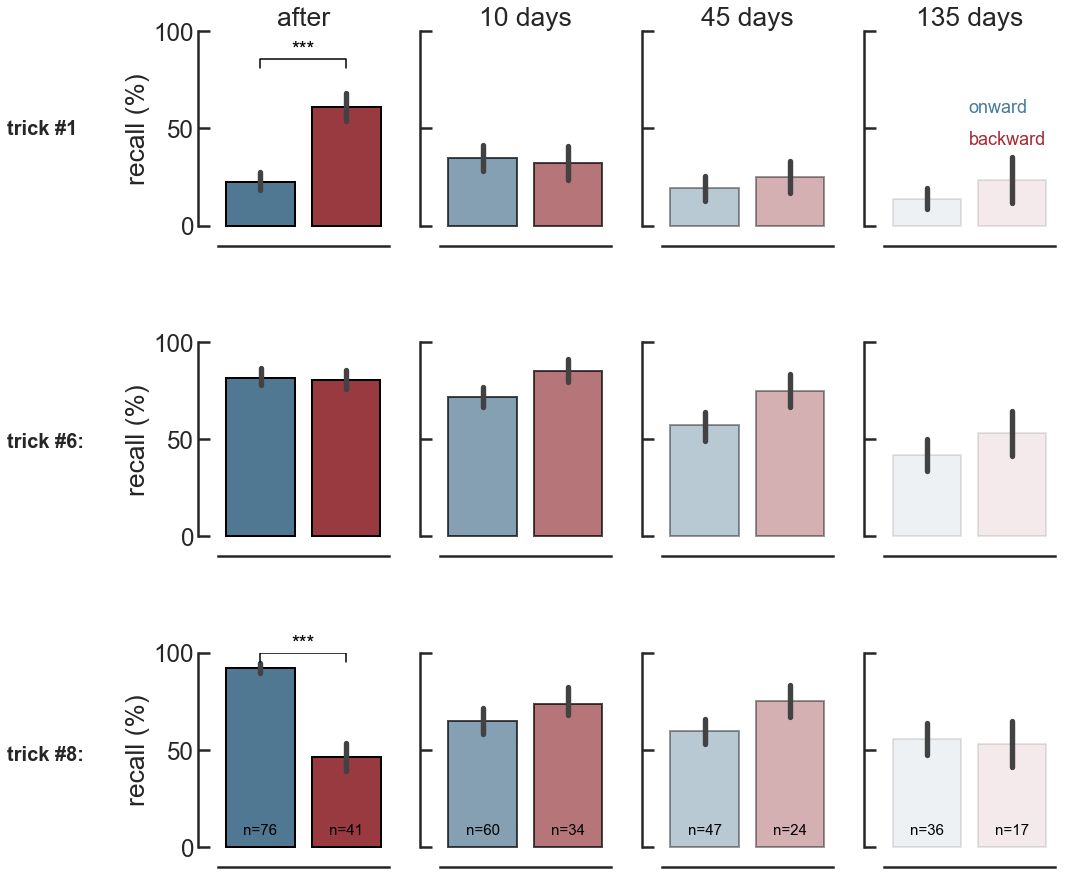

In [18]:
onwards = '#457b9d'
backwards = '#a82a33'

f = plt.figure(figsize=(15,15))
ax1 = f.add_subplot(341)
ax2 = f.add_subplot(342)
ax3 = f.add_subplot(343)
ax4 = f.add_subplot(344)

ax5 = f.add_subplot(345)
ax6 = f.add_subplot(346)
ax7 = f.add_subplot(347)
ax8 = f.add_subplot(348)


ax9 = f.add_subplot(349)
ax10 = f.add_subplot(3,4, 10)
ax11 = f.add_subplot(3,4, 11)
ax12 = f.add_subplot(3,4,12)


f.text(-0.07, 0.79, "trick #1", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=20)
f.text(-0.07, 0.5, "trick #6: ", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=20)
f.text(-0.07, 0.21, "trick #8: ", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=20)


axs=[ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12]
titulos=['after', '10 days', '45 days', '135 days']
alphas=[1, 0.7, 0.4, 0.1]
        
        
for idx_j, juego in enumerate([1,6,8]): #[1,8]
    #
    for idx_t, time in enumerate([1,2,3, 4]):
        axn=axs[4*idx_j + idx_t]
       
        sns.barplot(x="session_o", y="recuerdo", order=['normal', 'revés'], ax=axn, clip_on=False,
                    data=df_.loc[(df_['tiempo']==time) & (df_['juego']==juego)], estimator=np.mean, 
                     ci=68,  palette=[onwards, backwards], edgecolor='black', ecolor='k', alpha=alphas[idx_t])


        axn.spines['right'].set_visible(False)
        axn.spines['top'].set_visible(False)
        axn.tick_params(direction='in') #direction
        #
        
        if time==1:
            axn.set_yticks([0, 0.5, 1])
            axn.set_yticklabels(['0', '50', '100'])
            axn.set_ylabel('recall (%)')
        else:
            axn.set_yticks([0, 0.5, 1])
            axn.set_yticklabels(['', '', ''])
            axn.set_ylabel('')
            #
        #
        
        axn.set_xticklabels(['', ''])
        axn.set_xlabel('')
        
        if juego==1:
            axn.set_title(titulos[idx_t])
        
        ##
        axn.set_ylim(0,1)
        axn.tick_params(axis='x', length=0)
        
        ##statistical annotation
        number_detections_r = sum(df_.loc[(df_['tiempo']==time) & (df_['juego']==juego) & (df_['session_o']=='revés'), 'recuerdo'])
        number_obs_r = len(df_.loc[(df_['tiempo']==time) & (df_['juego']==juego) & (df_['session_o']=='revés'), 'recuerdo'])
        number_detections_n = sum(df_.loc[(df_['tiempo']==time) & (df_['juego']==juego) & (df_['session_o']=='normal'), 'recuerdo'])
        number_obs_n = len(df_.loc[(df_['tiempo']==time) & (df_['juego']==juego) & (df_['session_o']=='normal'), 'recuerdo'])

        count = np.array([number_detections_r, number_detections_n]);
        nobs = np.array([number_obs_r, number_obs_n]);
        stat, pval = proportions_ztest(count, nobs);
        #print(number_obs_n)
        #print(number_obs_r)
        #print(str(juego) + '_' + str(time) + ' ' + str(  round(pval,4)) )

        # statistical annotation
        x1, x2 = 0, 1   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
        y_sign = max( [df_.loc[(df_['tiempo']==time) & (df_['juego']==juego) & (df_['session_o']=='normal'), 'recuerdo'].mean() + 0.2, 
              df_.loc[(df_['tiempo']==time) & (df_['juego']==juego) & (df_['session_o']=='revés'), 'recuerdo'].mean() + 0.2] )
        if y_sign>1:
            y_sign=0.95

        h=0.05
        #y_sign = 0.8
        col='k'

        if pval<0.001:
            msg='***'
            axn.plot([x1, x1, x2, x2], [y_sign, y_sign+h, y_sign+h, y_sign], lw=1.5, c=col);
            axn.text((x1+x2)*.5, y_sign+h, msg, ha='center', va='bottom', color=col, fontsize=20);
        elif pval<0.01:
            msg='**'
            axn.plot([x1, x1, x2, x2], [y_sign, y_sign+h, y_sign+h, y_sign], lw=1.5, c=col);
            axn.text((x1+x2)*.5, y_sign+h, msg, ha='center', va='bottom', color=col, fontsize=20);
        elif pval<0.05:
            msg='*'
            axn.plot([x1, x1, x2, x2], [y_sign, y_sign+h, y_sign+h, y_sign], lw=1.5, c=col);
            axn.text((x1+x2)*.5, y_sign+h, msg, ha='center', va='bottom', color=col, fontsize=20);
        elif pval>=0.05:
            msg='ns'
            #no plot

        ### plot n
        if juego==8:
            axn.text(x1, 0.05, 'n=' + str(number_obs_n), ha='center', va='bottom', color=col, fontsize=15);
            axn.text(x2, 0.05, 'n=' + str(number_obs_r), ha='center', va='bottom', color=col, fontsize=15);
        
        
        
        adjust_spines(axn, ['left', 'bottom'])
        
    #

##
f.text(0.82, 0.81, "onward", horizontalalignment='left', verticalalignment='center', fontsize=18, color=onwards)
f.text(0.82, 0.78, "backward", horizontalalignment='left', verticalalignment='center', fontsize=18, color=backwards)
   

plt.subplots_adjust(wspace=0.3, hspace=0.6)
#plt.tight_layout()

### tricks with no recall at t=135 (supl. 8)

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


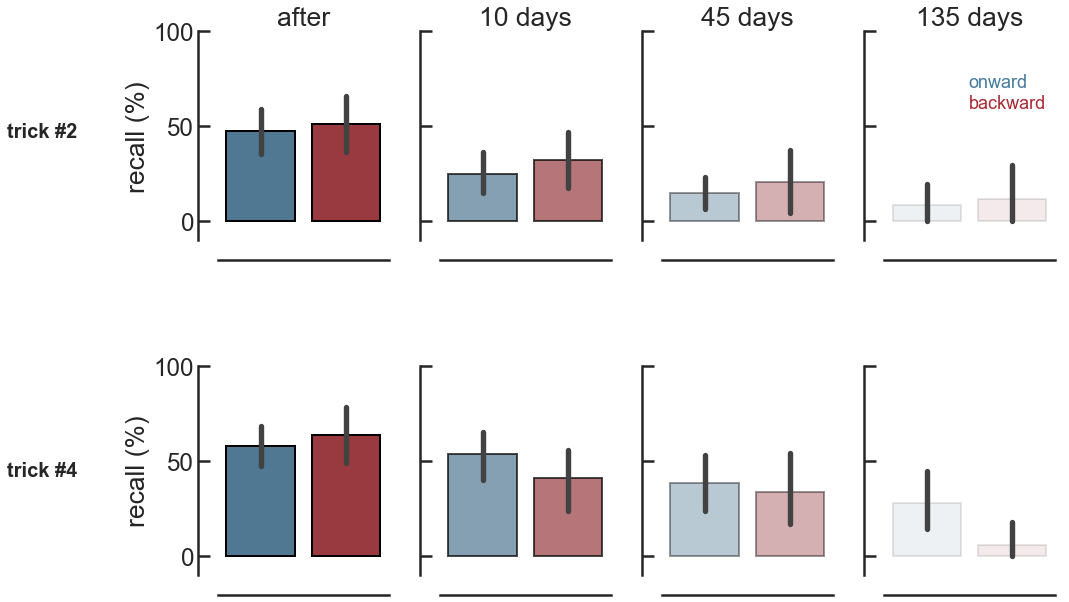

In [25]:
onwards = '#457b9d'
backwards = '#a82a33'

f = plt.figure(figsize=(15,10))
ax1 = f.add_subplot(241)
ax2 = f.add_subplot(242)
ax3 = f.add_subplot(243)
ax4 = f.add_subplot(244)

ax5 = f.add_subplot(245)
ax6 = f.add_subplot(246)
ax7 = f.add_subplot(247)
ax8 = f.add_subplot(248)

axs=[ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]
titulos=['after', '10 days', '45 days', '135 days']
alphas=[1, 0.7, 0.4, 0.1]
        
        
for idx_j, juego in enumerate([2,4]): #[1,8]
    if idx_j==0:
        f.text(-0.07, 0.74, "trick #" + str(juego), weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=20)
    else:
        f.text(-0.07, 0.27, "trick #" +str(juego), weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=20)
    #
    for idx_t, time in enumerate([1,2,3, 4]):
        axn=axs[4*idx_j + idx_t]
       
        sns.barplot(x="session_o", y="recuerdo", order=['normal', 'revés'], ax=axn, clip_on=False,
                    data=df_.loc[(df_['tiempo']==time) & (df_['juego']==juego)], estimator=np.mean, 
                     ci=95,  palette=[onwards, backwards], edgecolor='black', ecolor='k', alpha=alphas[idx_t])


        axn.spines['right'].set_visible(False)
        axn.spines['top'].set_visible(False)
        axn.tick_params(direction='in') #direction
        #
        
        if time==1:
            axn.set_yticks([0, 0.5, 1])
            axn.set_yticklabels(['0', '50', '100'])
            axn.set_ylabel('recall (%)')
        else:
            axn.set_yticks([0, 0.5, 1])
            axn.set_yticklabels(['', '', ''])
            axn.set_ylabel('')
            #
        #
        
        axn.set_xticklabels(['', ''])
        axn.set_xlabel('')
        
        if juego==2:
            axn.set_title(titulos[idx_t])
        
        ##
        axn.set_ylim(-0.1,1)
        axn.tick_params(axis='x', length=0)
        
        ##statistical annotation
        number_detections_r = sum(df_.loc[(df_['tiempo']==time) & (df_['juego']==juego) & (df_['session_o']=='revés'), 'recuerdo'])
        number_obs_r = len(df_.loc[(df_['tiempo']==time) & (df_['juego']==juego) & (df_['session_o']=='revés'), 'recuerdo'])
        number_detections_n = sum(df_.loc[(df_['tiempo']==time) & (df_['juego']==juego) & (df_['session_o']=='normal'), 'recuerdo'])
        number_obs_n = len(df_.loc[(df_['tiempo']==time) & (df_['juego']==juego) & (df_['session_o']=='normal'), 'recuerdo'])

        count = np.array([number_detections_r, number_detections_n]);
        nobs = np.array([number_obs_r, number_obs_n]);
        stat, pval = proportions_ztest(count, nobs);
        #print(pval)
        #print(number_obs_n)
        #print(number_obs_r)
        #print(str(juego) + '_' + str(time) + ' ' + str(  round(pval,4)) )

        # statistical annotation
        x1, x2 = 0, 1   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
        y_sign = max( [df_.loc[(df_['tiempo']==time) & (df_['juego']==juego) & (df_['session_o']=='normal'), 'recuerdo'].mean() + 0.2, 
              df_.loc[(df_['tiempo']==time) & (df_['juego']==juego) & (df_['session_o']=='revés'), 'recuerdo'].mean() + 0.2] )
        if y_sign>1:
            y_sign=0.95

        h=0.05
        #y_sign = 0.8
        col='k'

        if pval<0.001:
            msg='***'
            axn.plot([x1, x1, x2, x2], [y_sign, y_sign+h, y_sign+h, y_sign], lw=1.5, c=col);
            axn.text((x1+x2)*.5, y_sign+h, msg, ha='center', va='bottom', color=col, fontsize=20);
        elif pval<0.01:
            msg='**'
            axn.plot([x1, x1, x2, x2], [y_sign, y_sign+h, y_sign+h, y_sign], lw=1.5, c=col);
            axn.text((x1+x2)*.5, y_sign+h, msg, ha='center', va='bottom', color=col, fontsize=20);
        elif pval<0.05:
            msg='*'
            axn.plot([x1, x1, x2, x2], [y_sign, y_sign+h, y_sign+h, y_sign], lw=1.5, c=col);
            axn.text((x1+x2)*.5, y_sign+h, msg, ha='center', va='bottom', color=col, fontsize=20);
        elif pval>=0.05:
            msg='ns'
            #no plot

        ### plot n
        if juego==8:
            axn.text(x1, 0.05, 'n=' + str(number_obs_n), ha='center', va='bottom', color=col, fontsize=15);
            axn.text(x2, 0.05, 'n=' + str(number_obs_r), ha='center', va='bottom', color=col, fontsize=15);
        
        
        
        adjust_spines(axn, ['left', 'bottom'])
        
    #

##
f.text(0.82, 0.81, "onward", horizontalalignment='left', verticalalignment='center', fontsize=18, color=onwards)
f.text(0.82, 0.78, "backward", horizontalalignment='left', verticalalignment='center', fontsize=18, color=backwards)
   

plt.subplots_adjust(wspace=0.3, hspace=0.6)
#plt.tight_layout()

## Saliencias (supl. 6 & 7)

In [26]:
### Al convertir a xlsx se ha dado un error en como se ha guardado la lista. Con estas linesas se corrige
correct_saliencias=[]

for i in range(len(df_)):
    ini_list = df_.iloc[i].saliencias
    res = ini_list.strip('][').split(', ')
    for e in range(len(res)):
        res[e] = res[e].replace("'","")

    correct_saliencias.append(res)

##
df_['saliencias']=correct_saliencias

In [27]:

def map_book(tokens): #function to go from list of words to dictionari (take off punctuation and repetitions
    words_wp = []
    hash_map = {}
    if tokens is not None:
        for element in tokens:
            # Remove Punctuation
            word = element.replace(",","")
            word = word.replace(".","")
            word = word.replace("-","")
            word = word.replace(")","")
            word = word.replace("(","")
            words_wp.append(word)

            # Word Exist?
            if word in hash_map:
                hash_map[word] = hash_map[word] + 1
            else:
                hash_map[word] = 1

        return hash_map, words_wp
    else:
        return None

In [28]:
Saliencias_1 = ['joker', 'estuche', 'montones', 'color', 'encore', 'carta1', 'persona1']    
Saliencias_2 = ['frotar', 'dinerito', 'carta2', 'persona2', 'oportunidad', 'desaparecer', 'oreja']  
Saliencias_3= ['tapadas', 'viajes']  
Saliencias_4 = ['alma', 'predicción',  'persona4', 'carta4'] #'carta4',
Saliencias_5 = ['material', 'vaso', 'mesa', 'manos', 'salian'] 
Saliencias_6 = ['deletreo', 'tres', 'española', 'cualquiera', 'fallido', 'persona6', 'carta6'] 
Saliencias_7 = ['blancas', 'granada', 'tiempo', 'reunión', 'carta7'] 
Saliencias_8 = ['instrucciones', 'sube', 'carta8', 'persona8'] 
Saliencias_0 = ['m_interrogante'] 
Saliencias_9 = ['c_interrogante'] 
Saliencias_22 = ['monedón'] 
Saliencias_23 = ['técnico'] 
Saliencias_10 = ['otro'] 


Lists_saliencias= [Saliencias_1 , Saliencias_2, Saliencias_3, Saliencias_4, Saliencias_5,
                  Saliencias_6, Saliencias_7, Saliencias_8, Saliencias_0 , Saliencias_9,
                  Saliencias_22, Saliencias_23, Saliencias_10]


nombre_juegos=['Mi tiempo', 'Calentamiento', 'Matrix', 'Invisible', 'Esencia', 
               'Deletreo', 'Aparicio', 'Mensajes', 'm_interrogante', 'c_interrogante',
              'monedón', 'técnico', 'otro' ]

In [29]:
df_orden_sess=[]

for orden_ in ['normal','revés']:
    for time in [1,2,3,4]:
        df_s=df_.loc[ (df_['session_o']== orden_) & (df_['tiempo']== time) ]
        n_subjects = len(df_s.subj.unique())
        #print(n_subjects)
        ###Lineas necesarias para un df de saliencias (un subset)
        words_all = [] #brake the string into individual words and put them all there
        for i in range(len(df_s)):
            if df_s['saliencias'].iloc[i]==['']:
                pass
            else:
                words= df_s['saliencias'].iloc[i]
                l_w = len(words)
                [words_all.append(  words[n]  ) for n in range(l_w)]


        ###
        dict_words = map_book(words_all)[0]
        sortedkeys=sorted(dict_words.keys(), key=lambda x:x.lower()) ##list of uniques in alphabetical order 

        lst=[] ### Create Dataframe using a dictionary
        for w in sortedkeys:
            lst.append([w, dict_words[w]])

        df_salienc=pd.DataFrame(lst) ### Create Dataframe
        df_salienc.columns=['word', 'freq'] ### column names of the df
        df_salienc['freq_corr'] = df_salienc['freq']/n_subjects

        js=[]
        for n in range(len(df_salienc)):
            j_i = [df_salienc['word'].iloc[n] in Lists_saliencias[i] for i in range(13)]
            j= np.array(nombre_juegos)[np.array(j_i)]
            js.append(j[0])

        df_salienc['juego']=js
        df_salienc['orden']=orden_
        df_salienc['time'] = time
        df_orden_sess.append(df_salienc)
#


df_orden_sess=pd.concat(df_orden_sess)

In [30]:
orders_english=[[ 'joker', 'box', 'piles', 'color', 'encore', 'card', 'person'  ],
               ['rub', 'money', 'card', 'person', 'chance', 'disappear', 'ear'],
               ['covered', 'travell'],
               ['soul', 'prediction', 'person', 'card'],
               ['material', 'glass', 'table', 'hands', 'leave'],
               ['spelling', 'three', 'spanish', 'any', 'failed', 'card', 'person'],
               ['white', 'granada', 'time', 'assambly', 'card' ],
               ['instructions', 'rise', 'card', 'person']]

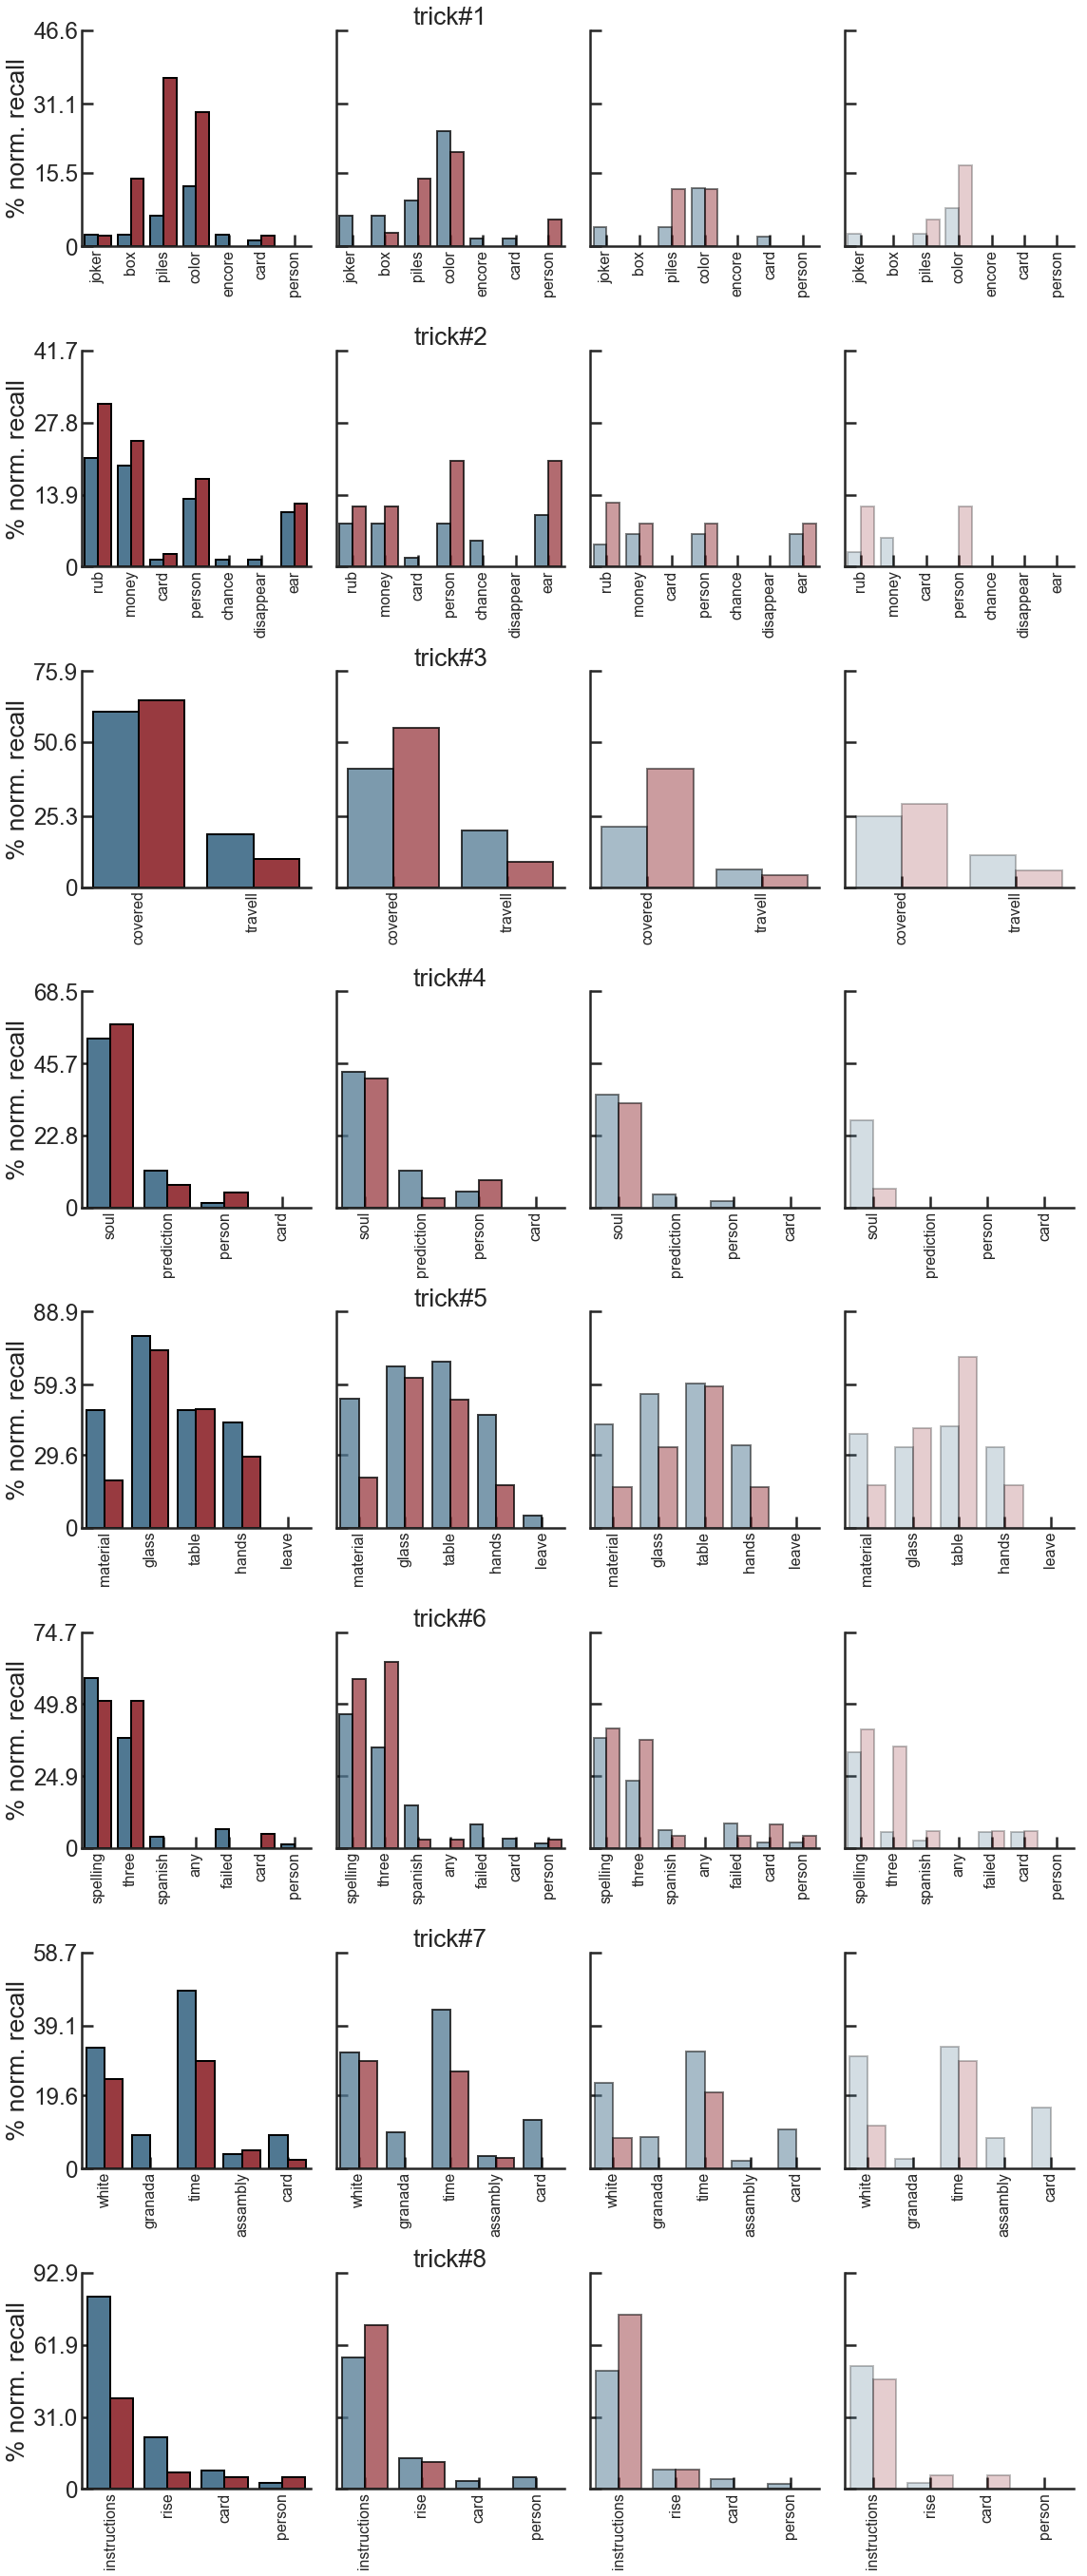

In [31]:
normal_c = '#457b9d'
reves_c = '#a82a33'

f = plt.figure(figsize=(16,60))

nombre_juegos_ = ['trick#1', 'trick#2', 'trick#3', 'trick#4',
                'trick#5', 'trick#6', 'trick#7', 'trick#8']

AXN = [f.add_subplot(13,4,n) for n in range(1, 8*4 +1)]

juegos_ = [1,2,3,4,5,6,7,8]#, 9, 10, 11, 12, 13]
times_ = [1,2,3,4]
alphas=[1, 0.75, 0.5, 0.25]



for idx_j, juego in enumerate(juegos_):
    order_ = Lists_saliencias[idx_j]
    title=nombre_juegos[idx_j]    
    title_=nombre_juegos_[idx_j] 
    for idx_t, Time in enumerate(times_):
            axn=AXN[4*idx_j + idx_t]
            ##            
            g=sns.barplot(x="word", y="freq_corr", order=order_, hue='orden', 
                          hue_order=['normal', 'revés'],  
                          data=df_orden_sess.loc[(df_orden_sess['juego']==title) & (df_orden_sess['time']==Time)], 
                          estimator=np.mean, ax=axn, palette=[normal_c, reves_c], 
                          edgecolor='black', ecolor='k', alpha=alphas[idx_t])
            
            ##
            axn.set_xticklabels(order_, rotation=90, fontsize=16);
            axn.set_xlabel('')
            if idx_t == 1:
                axn.set_title(title_)
            else:
                axn.set_title('')
            ##
            ##                
            max_= df_orden_sess.loc[df_orden_sess['juego']==title].freq_corr.max() + 0.1
            #if max_>1:
            #    max_=1
            axn.set_ylim(0, max_)
            if idx_t == 0:
                axn.set_ylabel('% norm. recall')
                axn.set_yticks([0, round(max_/3,2), round(2*max_/3,2), round(max_,2)])
                axn.set_yticklabels([0, round(max_/3*100, 1), round(2*max_/3*100, 1), round(max_*100,1)])
            else:
                axn.set_ylabel('')
                axn.set_yticks([0, round(max_/3,2), round(2*max_/3,2), round(max_,2)])
                axn.set_yticklabels(['', '',  '', ''])
                

            axn.spines['right'].set_visible(False)
            axn.spines['top'].set_visible(False)
            axn.tick_params(direction='in') #direction
            g.legend_.remove()
            
            order_e = orders_english[idx_j]
            axn.set_xticklabels(order_e, rotation=90, fontsize=16);
            axn.set_xlabel('')
            ##
        

            
            
    
#
plt.tight_layout()

In [32]:
for idx, j in enumerate(nombre_juegos):    
    for time in [1,2,3,4]:
        ws = Lists_saliencias[idx]
        for w in ws:
            try:
                counts_normal = df_orden_sess.loc[(df_orden_sess['juego']==j) & (df_orden_sess['word']==w) & (df_orden_sess['time']==time) & (df_orden_sess['orden']=='normal'), 'freq'].values[0]
                counts_reves = df_orden_sess.loc[(df_orden_sess['juego']==j) & (df_orden_sess['word']==w) & (df_orden_sess['time']==time) & (df_orden_sess['orden']=='revés'), 'freq'].values[0]
                obs_normal = len( df_.loc[ (df_['session_o']== 'normal') &   (df_['tiempo']== time) ].subj.unique() ) 
                obs_reves = len( df_.loc[(df_['session_o']== 'revés') &   (df_['tiempo']== time)].subj.unique() ) 
                count = np.array([counts_normal, counts_reves]);
                nobs = np.array([obs_normal, obs_reves]);
                stat, pval = proportions_ztest(count, nobs);
                if pval<0.05:
                    print(str(time) + ' ' + j + '-' + w + ':  ' + 't=' + str(round(stat,3)) + ', p=' + str(round(pval,3)))
                else:
                    pass
                    #print(str(time) + ' ' + j + '-' + w + ':  ns')

            except IndexError:
                pass
                #print(str(time) + ' ' + j + '-' + w + ':  ' + 'missing')

1 Mi tiempo-estuche:  t=-2.454, p=0.014
1 Mi tiempo-montones:  t=-4.113, p=0.0
1 Mi tiempo-color:  t=-2.128, p=0.033
1 Esencia-material:  t=3.094, p=0.002
2 Esencia-material:  t=3.096, p=0.002
2 Esencia-manos:  t=2.814, p=0.005
3 Esencia-material:  t=2.181, p=0.029
4 Esencia-mesa:  t=-1.966, p=0.049
2 Deletreo-tres:  t=-2.778, p=0.005
4 Deletreo-tres:  t=-2.823, p=0.005
1 Aparicio-tiempo:  t=2.031, p=0.042
1 Mensajes-instrucciones:  t=4.835, p=0.0
1 Mensajes-sube:  t=2.063, p=0.039


In [33]:
for idx, j in enumerate(nombre_juegos):    
    for time in [1,2,3,4]:
        ws = Lists_saliencias[idx]
        for w in ws:
            try:
                counts_normal = df_orden_sess.loc[(df_orden_sess['juego']==j) & (df_orden_sess['word']==w) & (df_orden_sess['time']==time) & (df_orden_sess['orden']=='normal'), 'freq'].values[0]
                counts_reves = df_orden_sess.loc[(df_orden_sess['juego']==j) & (df_orden_sess['word']==w) & (df_orden_sess['time']==time) & (df_orden_sess['orden']=='revés'), 'freq'].values[0]
                obs_normal = len( df_.loc[ (df_['session_o']== 'normal') &   (df_['tiempo']== time) ].subj.unique() ) 
                obs_reves = len( df_.loc[(df_['session_o']== 'revés') &   (df_['tiempo']== time)].subj.unique() ) 
                count = np.array([counts_normal, counts_reves]);
                nobs = np.array([obs_normal, obs_reves]);
                stat, pval = proportions_ztest(count, nobs);
                if pval<0.05:
                    print(str(time) + ' ' + j + '-' + w + ':  ' + 't=' + str(round(stat,3)) + ', p=' + str(round(pval,3)))
                else:
                    print(str(time) + ' ' + j + '-' + w + ':  ns')

            except IndexError:
                print(str(time) + ' ' + j + '-' + w + ':  ' + 'missing')

1 Mi tiempo-joker:  ns
1 Mi tiempo-estuche:  t=-2.454, p=0.014
1 Mi tiempo-montones:  t=-4.113, p=0.0
1 Mi tiempo-color:  t=-2.128, p=0.033
1 Mi tiempo-encore:  missing
1 Mi tiempo-carta1:  ns
1 Mi tiempo-persona1:  missing
2 Mi tiempo-joker:  missing
2 Mi tiempo-estuche:  ns
2 Mi tiempo-montones:  ns
2 Mi tiempo-color:  ns
2 Mi tiempo-encore:  missing
2 Mi tiempo-carta1:  missing
2 Mi tiempo-persona1:  missing
3 Mi tiempo-joker:  missing
3 Mi tiempo-estuche:  missing
3 Mi tiempo-montones:  ns
3 Mi tiempo-color:  ns
3 Mi tiempo-encore:  missing
3 Mi tiempo-carta1:  missing
3 Mi tiempo-persona1:  missing
4 Mi tiempo-joker:  missing
4 Mi tiempo-estuche:  missing
4 Mi tiempo-montones:  ns
4 Mi tiempo-color:  ns
4 Mi tiempo-encore:  missing
4 Mi tiempo-carta1:  missing
4 Mi tiempo-persona1:  missing
1 Calentamiento-frotar:  ns
1 Calentamiento-dinerito:  ns
1 Calentamiento-carta2:  ns
1 Calentamiento-persona2:  ns
1 Calentamiento-oportunidad:  missing
1 Calentamiento-desaparecer:  missing
1

In [75]:
##Perecentage of null repsonses
total_nonull = sum([df_['saliencias'].iloc[i] !=['']  for i in range(len(df_))])
indet_resp = sum([df_['saliencias'].iloc[i] == ['c_interrogante'] for i in range(len(df_))]) + sum([df_['saliencias'].iloc[i] == ['m_interrogante'] for i in range(len(df_))])
##

percent = round(indet_resp*100/(total_nonull-indet_resp),2)
percent

5.76